### Energy Consultation Analysis

***Please note: ***
Throughout the analysis, I am assuming this data comes from Enter's energy consultation 
(cf. Enter (2024), Foederservice,  https://www.enter.de/foerderservice)

In [1]:
#Data Manipulation libaries 

import pandas as pd
import numpy as np

#Data visualisation libraries

import matplotlib.pyplot as plt
import seaborn as sns

1) Data Preparation

Loading the datasets

In [2]:
orders_df = pd.read_csv('orders.csv', dtype= {'postal_code': str}) 
appointments_df = pd.read_csv('appointments.csv')


Converting datatypes

In [3]:
# Checking the datatypes of each column in orders_df
orders_df.dtypes

# Checking the datatypes of each column in appointments_df
appointments_df.dtypes

# Converting the datetime columns to datetime format
appointments_df['timestamp'] = pd.to_datetime(appointments_df['timestamp'], format='%d/%m/%Y %H:%M')
orders_df['order_date'] = pd.to_datetime(orders_df['order_date'], format='%d/%m/%Y %H:%M')

In [4]:
# Counting the number of rows in each dataset
appointments_count = appointments_df.shape[0]
orders_count = orders_df.shape[0]

# Calculating the percentage difference
percentage_difference = ((orders_count - appointments_count) / appointments_count) * 100

appointments_count, orders_count, percentage_difference

# -> There are 34240 entries more in appointments_df than there are in orders_df, showing a difference of ~60%

(56384, 22144, -60.726447219069236)

Identifaction of missing values

In [5]:
# Dropping null values in orders_df
orders_df.dropna(subset = ['postal_code'], inplace = True) 
#Here, null values are dropped to ensure the visuals are accurate. Why is this data absent? -> Was this field e.g. overseen when filling out the contact form?
# Dropping null values in appointment_df
appointments_df['type'] = appointments_df['type'].str.strip()
appointments_df.dropna(subset=['customer_id'], inplace=True) #Why was there no customer_id created?
appointments_df.dropna(subset = ['type'], inplace = True) 
# In this analysis I assume missing data were typos. However, these could also be canceled orders after the order date. What is the reason for this missing data?
#Dropping null values to ensure the visuals are accurate and meaningful. 
appointments_df = appointments_df.loc[appointments_df['type']!='',:]

# Column Timestamp is not dropped for now as it may bias the analysis if analysed e.g. "How many clients did not finish until the final call appointment?"
#-> why is there no timestamp?
print(appointments_df.isnull().sum())
print(orders_df.isnull().sum())

customer_id       0
timestamp      3412
type              0
dtype: int64
order_date      0
customer_id     0
postal_code     0
account_type    0
dtype: int64


Identification of duplicated values

In [6]:
# Checking for the number of unique customer IDs in appointment_df

appointments_df['customer_id'].nunique()
appointments_df['customer_id'].duplicated

<bound method Series.duplicated of 0        ff58fb3560
1        33dde97d25
2        3afa03aa1c
3        b823fbed0b
4        be0b8b0205
            ...    
56376    6c74178df3
56377    92a1193074
56379    d767f901b2
56382    6ce541e8ed
56383    2a0a2be849
Name: customer_id, Length: 53296, dtype: object>

In [7]:
# Calculating the number of unique customer_id values
unique_customer_id_count = appointments_df['customer_id'].nunique()
unique_timestamp_count = appointments_df['timestamp'].nunique()
unique_type_count = appointments_df['type'].nunique()

# Grouping by customer ID to check if every customer ID has a different timestamp (incl. date and time) and type pairs.
grouped_appointments_df = (appointments_df.groupby('customer_id').apply(lambda x: x[['timestamp', 'type']].shape[0]).reset_index(name='unique_count'))
grouped_appointments_df



C:\Users\Katha\AppData\Local\Temp\ipykernel_7792\843616958.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_appointments_df = (appointments_df.groupby('customer_id').apply(lambda x: x[['timestamp', 'type']].shape[0]).reset_index(name='unique_count'))


,customer_id,unique_count
0,0005cfd259,2
1,00089e61da,2
2,00164ae846,3
3,0018b37947,3
4,001ac46a49,3
...,...,...
19977,fff3178a0e,3
19978,fff36c43ce,1
19979,fff4b9927a,3
19980,fff981654d,3


In [8]:
#Validation: Matching if every the sum of the unique_counts matches the total number of customer ID in appointments_df

grouped_appointments_df['unique_count'].sum() == appointments_df['customer_id'].count()

np.True_

In [9]:
print(appointments_df['customer_id'].count())
print(orders_df['customer_id'].count())

53296
19930


2) Merging both dataframes

In [10]:
merged_df = pd.merge(appointments_df, orders_df , how = 'left', on = 'customer_id')
merged_df

,customer_id,timestamp,type,order_date,postal_code,account_type
0,ff58fb3560,2024-01-10 11:45:00,final_call,NaT,NaN,NaN
1,33dde97d25,2023-10-27 13:30:00,on_site_appointment,2023-09-20 00:00:00,73086,A
2,3afa03aa1c,2023-10-16 17:30:00,on_site_appointment,2023-09-19 00:00:00,79431,A
3,b823fbed0b,2023-12-11 08:15:00,project_call,2023-10-05 00:00:00,26272,A
4,be0b8b0205,2023-10-09 13:45:00,project_call,NaT,NaN,NaN
...,...,...,...,...,...,...
53291,6c74178df3,2023-12-08 16:15:00,final_call,2023-10-18 01:00:00,83425,A
53292,92a1193074,2023-12-07 10:45:00,project_call,2023-10-31 01:00:00,70253,A
53293,d767f901b2,2023-10-04 11:00:00,project_call,2023-09-18 03:00:00,84191,A
53294,6ce541e8ed,2023-10-24 09:30:00,on_site_appointment,2023-09-27 00:00:00,31114,A


3) Exploratory Data Analysis

3.1. Order Processing Analysis

Variable Definitions

***Order_date Definition***

order_df, column: "order_date"

1) order_date: Once the client shares the house data and documents digitally with Enter, the order is placed.
2) account_type: Represents different types of customer accounts. Account Type "A" accounts for Individual Customers.

A: Individual or Retail Customers

***Appointment Type Definition***

appointments_df, column: "type"

There are three different appointment types:

2) on_site_appointment: To create the renovation roadmap, the current state of the property is identified using a digital 3D model. Therefore, an on-site appointment is arranged.
3) project_call: The next step is a 60-minute detailed consultation call  with the client.
4) final_call: In order to receive the maximum subsidy, the savings of each measure are calculated and when they will be amortised. The renovation roadmap is discussed in the final call. The refurbishment roadmap is discussed during the final call.

***-> Please note: I am assuming this data comes from Enter's energy consultation (cf. Enter (2024), Foederservice,  https://www.enter.de/foerderservice) ***

***Who are the customers? How many customers placed an order?***

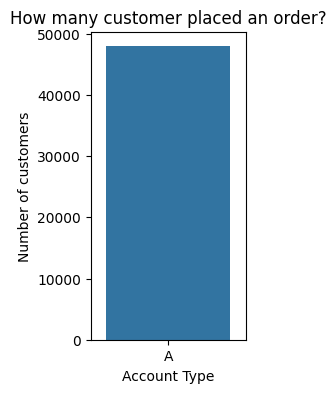

In [11]:
#print(merged_df['account_type'].value_counts())
plt.figure(figsize=(2, 4))

sns.countplot(x='account_type',data=merged_df)

plt.title('How many customer placed an order?')
plt.xlabel('Account Type')
plt.ylabel('Number of customers')

plt.show()

All the orders were placed by our individual customers.

In [12]:
#When an order is placed, how long does it take to have the first appointment?
# ->  What is the time difference between order_date and the on_site_appointment? 

# Creating column number_of_days_from_order_date to calculate the difference between the order placed and timestamp
merged_df['number_of_days_from_order_date'] = merged_df.apply(lambda row: (row['timestamp'] - row['order_date']).days, axis=1)
merged_df['number_of_days_from_order_date'] = merged_df['number_of_days_from_order_date'].astype('Int64')
merged_df.head()



,customer_id,timestamp,type,order_date,postal_code,account_type,number_of_days_from_order_date
0,ff58fb3560,2024-01-10 11:45:00,final_call,NaT,NaN,NaN,<NA>
1,33dde97d25,2023-10-27 13:30:00,on_site_appointment,2023-09-20,73086,A,37
2,3afa03aa1c,2023-10-16 17:30:00,on_site_appointment,2023-09-19,79431,A,27
3,b823fbed0b,2023-12-11 08:15:00,project_call,2023-10-05,26272,A,67
4,be0b8b0205,2023-10-09 13:45:00,project_call,NaT,NaN,NaN,<NA>


***When an order is placed, how many days does it take for each appointment type to be processed?*** 

In [13]:
descriptive_stats = merged_df.groupby('type')['number_of_days_from_order_date'].describe()
print(descriptive_stats)

                       count       mean        std   min   25%   50%   75%  \
type                                                                         
final_call           14497.0  52.054701  25.228866  10.0  35.0  46.0  62.0   
on_site_appointment  15525.0  27.360193   20.16088   0.0  15.0  21.0  33.0   
project_call         14829.0  41.836739  24.430892   7.0  26.0  35.0  49.0   

                       max  
type                        
final_call           173.0  
on_site_appointment  150.0  
project_call         147.0  


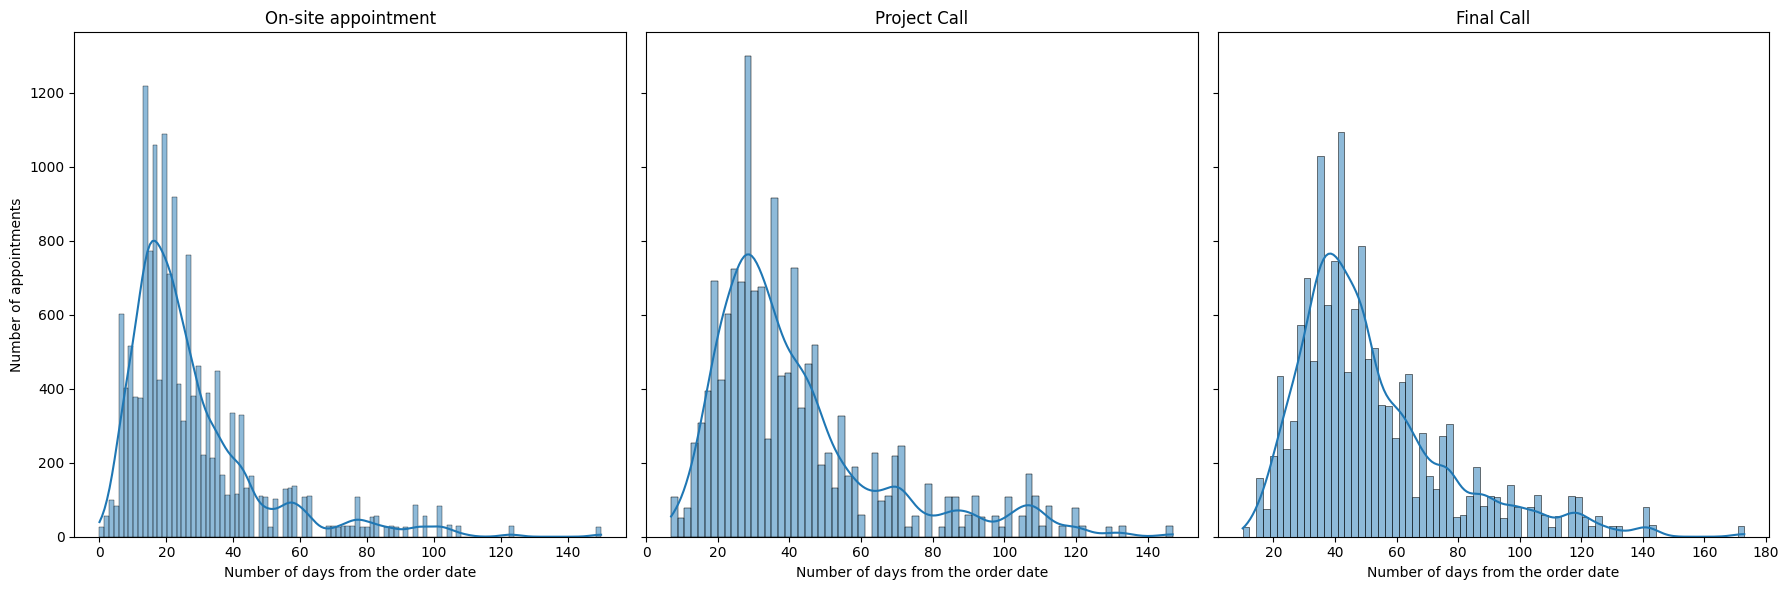

In [14]:
# Filting for each app. type

on_site_appointment = merged_df[merged_df['type'] == 'on_site_appointment']
project_call = merged_df[merged_df['type'] == 'project_call']
final_call = merged_df[merged_df['type'] == 'final_call']

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Creating the boxplots

sns.histplot(x='number_of_days_from_order_date', data=on_site_appointment, ax=axes[0], kde = True)
axes[0].set_title('On-site appointment')
axes[0].set_xlabel('Number of days from the order date')

sns.histplot(x='number_of_days_from_order_date', data=project_call, ax=axes[1], kde = True)
axes[1].set_title('Project Call')
axes[1].set_xlabel('Number of days from the order date')

sns.histplot(x='number_of_days_from_order_date', data=final_call, ax=axes[2], kde = True)
axes[2].set_title('Final Call')
axes[2].set_xlabel('Number of days from the order date')

# Setting common y-label
axes[0].set_ylabel('Number of appointments')

# Adjusting the layout
plt.tight_layout()
plt.show()

*** Please note: The histogram for appointment types is skewed to the right. Given the sensitivity of the mean to outliers, the median is used.**

The Data Team analysed how long it takes to schedule different types of appointments after an order is placed by the client. 

(1) On-site Appointment

- Typical time until the on-site appointment: From the order date, half of the appointments take place within 21 days. 
- Usual time range: Half of the appointments happen within 15 to 33 days.
- Delays: There are cases where it takes up to 60 days or longer.

(2) Project Call

- Typical time until the on-site appointment: Half of the project calls are scheduled within 35 days from the order date.
- Usual time range: Half of the project calls take place within 26 to 49 days.
- Delays: Some project calls exceed 83 days in certain cases.

(3) Final Call

- Typical time until the on-site appointment: From the order date, half of the final calls are scheduled within 46 days.
- Usual time range: Half of the final calls are scheduled within 35 days to 62 days.
- Delays: There are some final calls taking over 102 days to schedule.

Why these insights are relevant to Enter:

- Project Planning: Having these timelines supports in planning the process , but also setting realistic expectations towards customers.
- Optimisation: Identifying and investigating delays can support to optimise the processes, but also to reduce scheduling times.

Potential next steps:

- Investigating delays: We could check for reasons for delays,  especially those appointments that take much longer than usual. -> Why do these delays happen?
- Optimise schedulig: These data insights can support to streamline and optimise the scheduling processes to serve clients as best as possible.

***What is the proportion of each appointment type compared to the total appointments?***

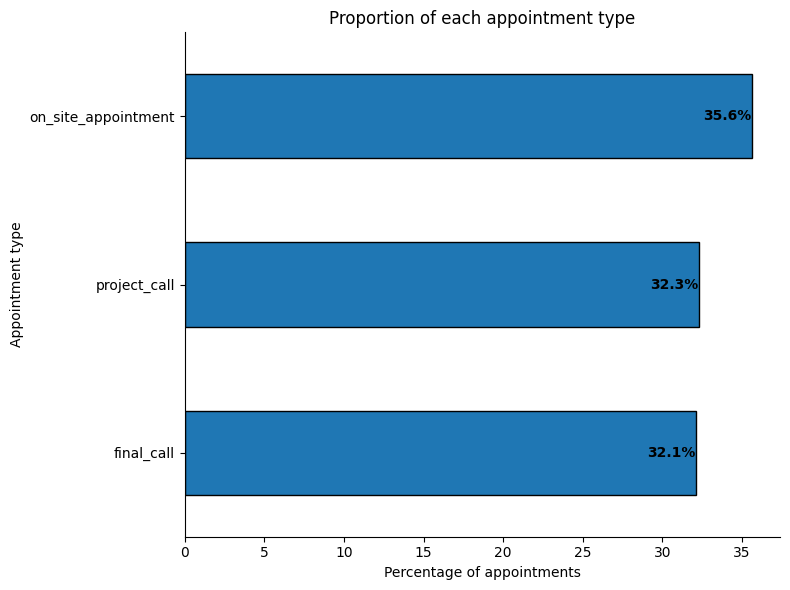

In [15]:
#What is the proportion of each appointment type?
value_counts_type = merged_df['type'].value_counts().sort_values()
#print(value_counts_type)

# What is the total number of appointments types?
total_appointments = merged_df['type'].count()
#print(total_appointments)

# Calculating the percentages for each appointment type
percentages = (value_counts_type / total_appointments) * 100

#  Plotting the bar chart to show the proportions of each type in percentage
plt.figure(figsize=(8, 6))
ax = percentages.plot(kind='barh', edgecolor='black', title='Proportion of each appointment type')

# Setting the labels
ax.set_xlabel('Percentage of appointments')
ax.set_ylabel('Appointment type')

# Annotating  bars with percentages
for index, value in enumerate(percentages):
    ax.text(value, index, f'{value:.1f}%', va='center', ha='right', color='black', fontweight='bold')

# Hiding the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.tight_layout()
plt.show()

Around 35.6% of appointments schedule are on-site. 32.3% were project calls and 32.1% were final calls. 

There are 3.3% less project calls and 3.5% less final calls than on-site appointments. Could the process not be continued? What is the reason for this difference? 
-> Understanding this could help to improve the on-site appointment to increase the probability of these these customers to continue the process.

3.2. Regions by postal code analysis

3.2. is based on the following assumpions:
- There are postal codes that show four digits. I assume that the "0" was missing for (e.g. for places in Saxony starting with "0"). Therefore, those postal codes starting with a "0" are matching the other 5-digit postal codes.

In [16]:
#Handling all 4-digit postal codes and annotate a "0"

# Creating a function to format postal codes
def format_postal_code(postal_code):
    try:
        if np.isnan(float(postal_code)):
            return postal_code
        return postal_code.zfill(5)
    except ValueError:
        return postal_code.zfill(5)

# Apply formatting to the 'postal_code' column
merged_df['postal_code'] = merged_df['postal_code'].apply(format_postal_code)
merged_df.dropna(subset=['postal_code'], inplace=True)

# Display the updated DataFrame
print(merged_df['postal_code'])


1        73086
2        79431
3        26272
5        49515
6        64373
         ...  
53291    83425
53292    70253
53293    84191
53294    31114
53295    27525
Name: postal_code, Length: 47927, dtype: object


In [17]:
# Extracting the first digit of the postal code to group by region

merged_df['first_digit'] = merged_df['postal_code'].str[0]

# Ensure the new column is of type string
merged_df['first_digit'] = merged_df['first_digit'].astype(str)


In [18]:
# Descriptive Statistics

region_descriptive_stats = merged_df.groupby('first_digit')['number_of_days_from_order_date'].describe()
print(region_descriptive_stats)

              count       mean        std  min    25%   50%   75%    max
first_digit                                                             
0            1680.0  39.695238  25.984578  5.0  19.75  29.0  53.0  107.0
1            6933.0   45.19674  29.504588  3.0   24.0  37.0  57.0  173.0
2            5611.0   37.52201  22.428862  2.0   21.0  34.0  49.0  147.0
3            3653.0  45.932384    29.3308  6.0   26.0  36.0  59.0  143.0
4            5914.0  40.161481  22.684226  6.0   23.0  35.0  53.0  112.0
5            4630.0  39.222894   22.48992  4.0   24.0  35.0  48.0  141.0
6            5477.0  38.270586  25.299474  2.0   20.0  32.0  47.0  140.0
7            5627.0  35.893727  21.931836  3.0   21.0  31.0  45.0  150.0
8            3459.0  39.157271  25.234977  0.0   22.0  34.0  48.0  126.0
9            1867.0  40.328334  29.532021  5.0   21.0  34.0  50.0  133.0


***In which regions are most appointments types taking place?***

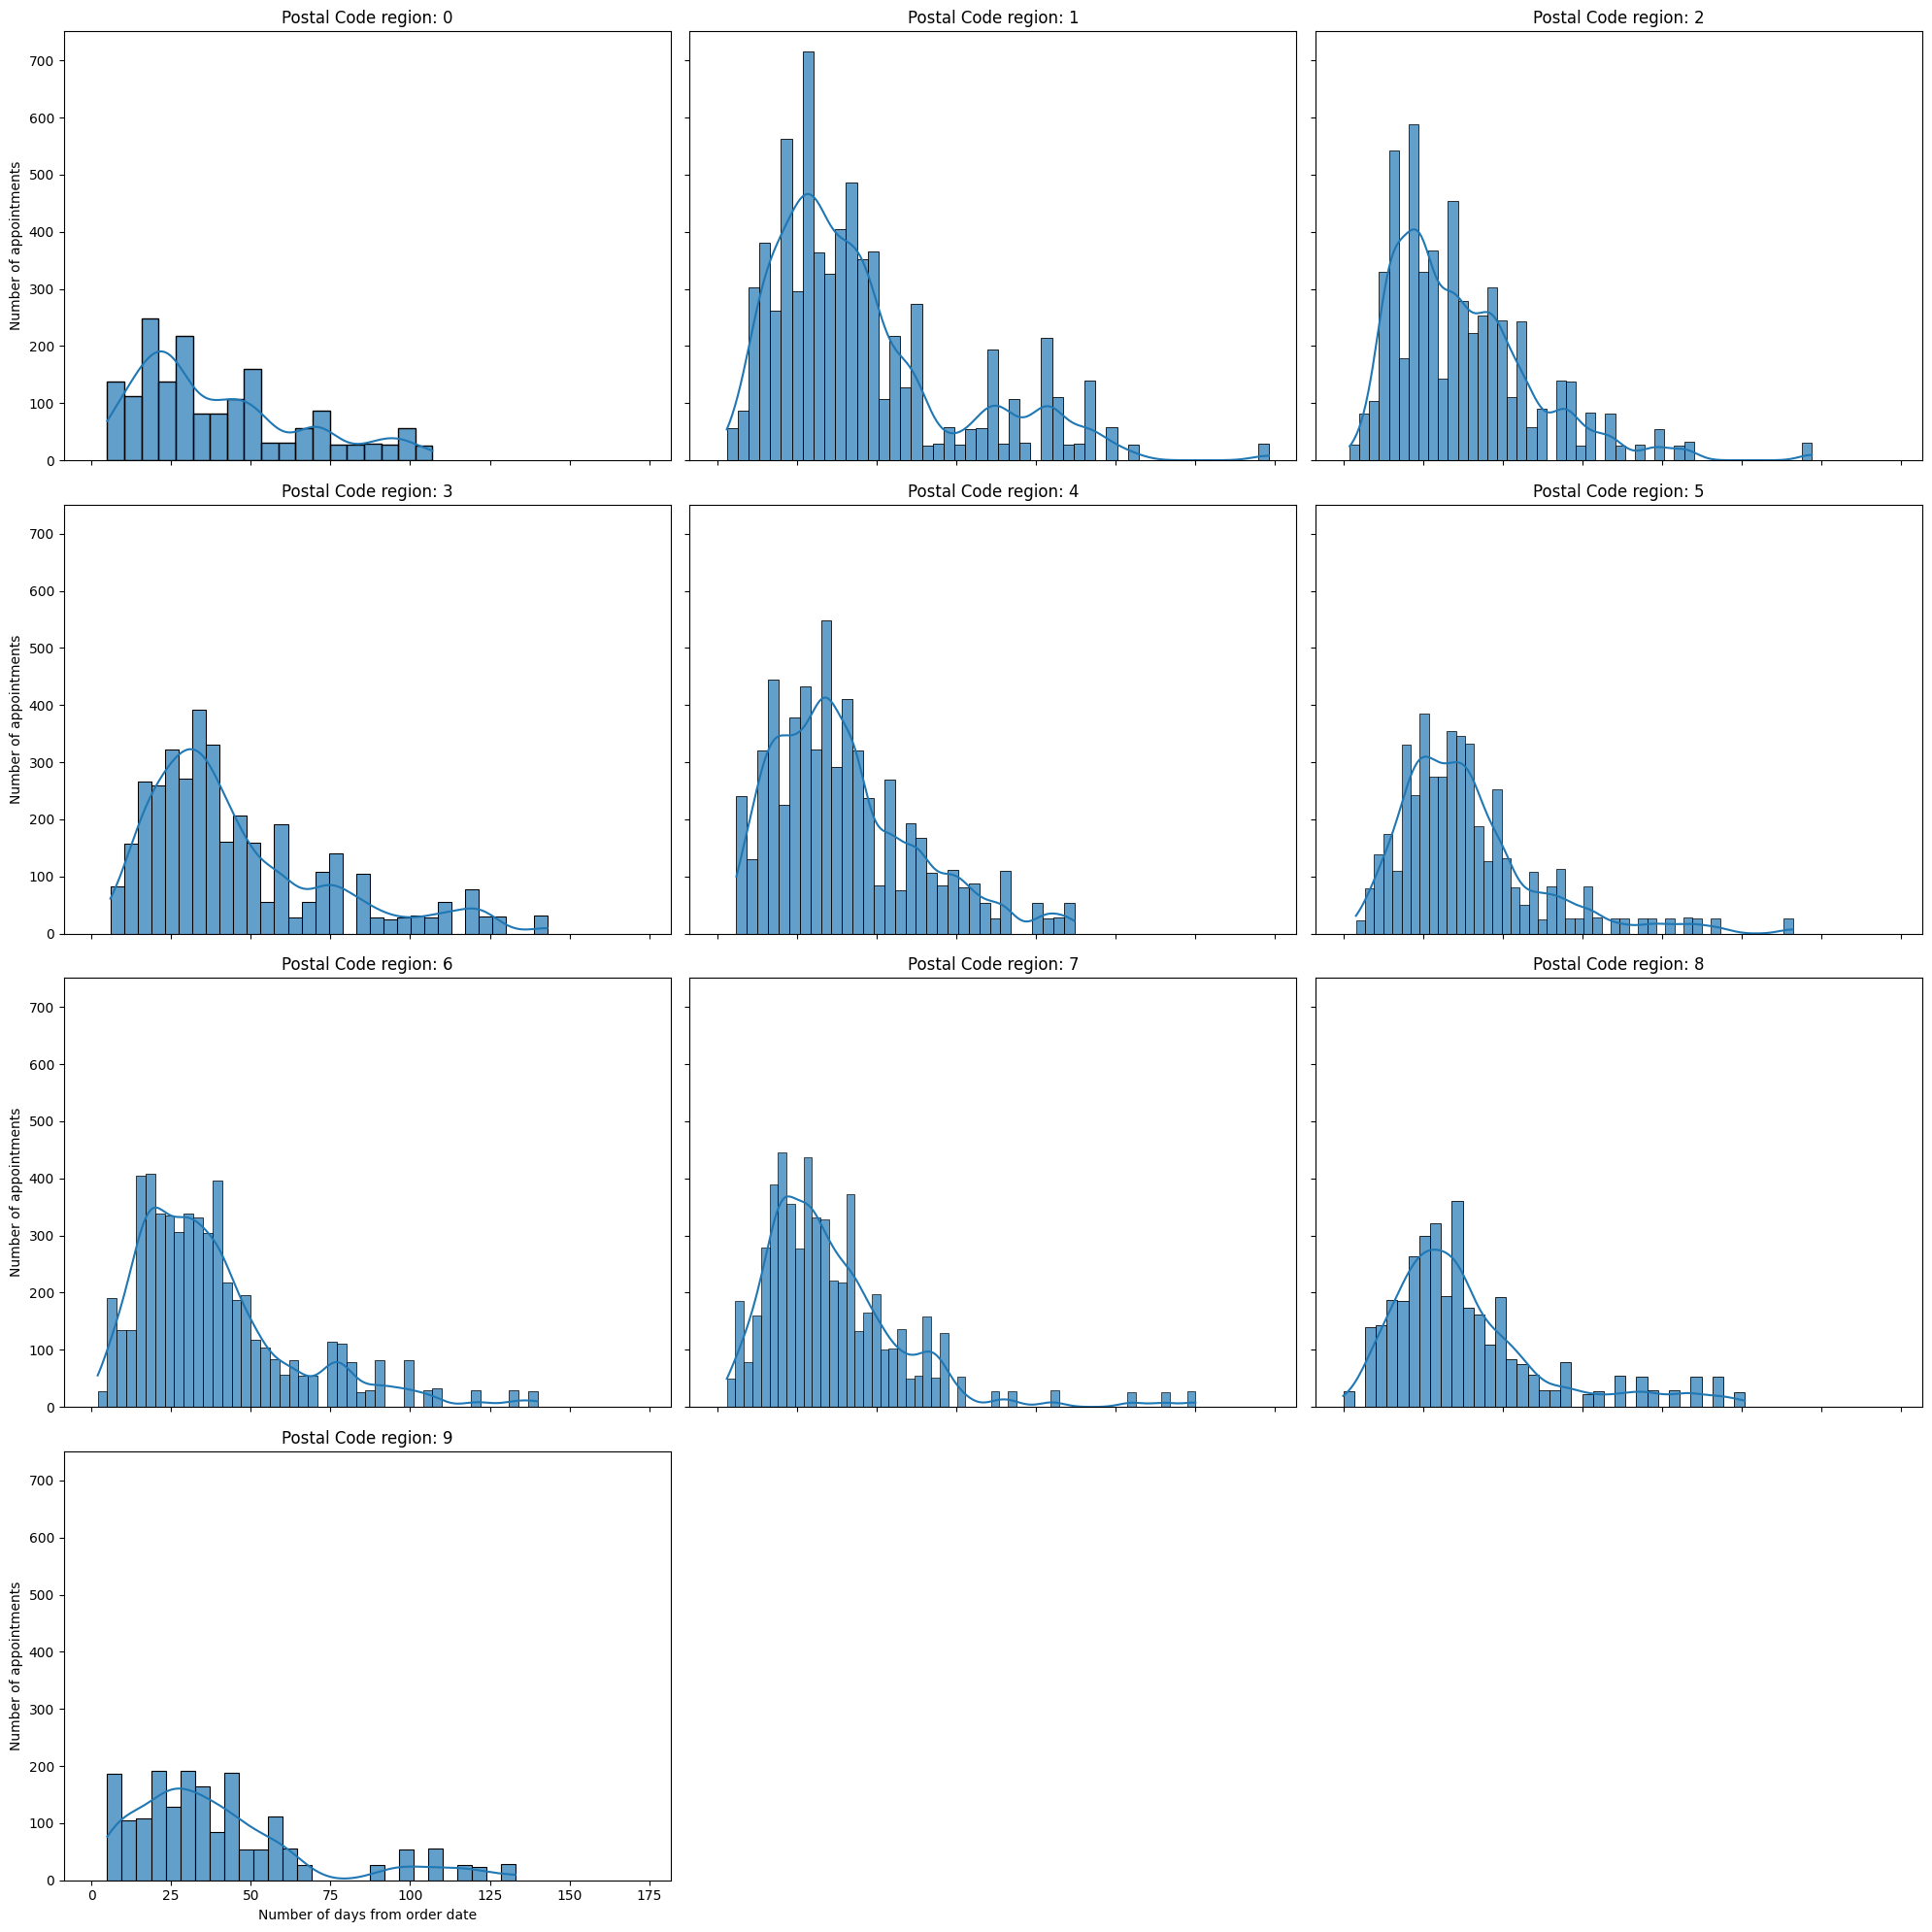

In [19]:
first_digits = sorted(merged_df['first_digit'].unique())

# Number of columns in the subplot grid
num_columns = 3
num_digits = len(first_digits)
num_rows = (num_digits + num_columns - 1) // num_columns  # Calculate the number of rows needed

# Setting up the subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20,5 * num_rows), sharex=True, sharey=True)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plotting a histogram  for each first digit of the postal code (region)
for i, digit in enumerate(first_digits):
    subset = merged_df[merged_df['first_digit'] == digit]
    sns.histplot(subset['number_of_days_from_order_date'], kde=True, ax=axes[i], edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Postal Code region: {digit}')
    axes[i].set_xlabel('Number of days from order date')
    axes[i].set_ylabel('Number of appointments')

# Hiding  extra subplots if there are fewer digits than slots

for j in range(len(first_digits), len(axes)):
    fig.delaxes(axes[j])

# Adjusting layout to not overlap
plt.tight_layout()
plt.show()

Summary for each postal code area:

- Postal Code Area 0: Half of the appointments are scheduled with 29 days . Some are processed very quickly (5 days), while others take as long up to 107 days.
- Postal Code Area 1: Scheduling an appointment takes around 37 days for half of the appointments. On the other hand, there are orders taking up to 173 days.
- Postal Code Area 2: Orders are processed in about 34 days. Most are processed within 2 to 147 days.
- Postal Code Area 3: It takes about 36 days, with a wide range from 6 to 143 days.
- Postal Code Area 4: Half orders are being processed within 35 days, with most orders falling between 6 and 112 days.
- Postal Code Area 5: It takes about 35 days on for half of the orders to process, ranging from 4 to 141 days.
- Postal Code Area 6: The processing time is 32 days for half of the orders , with a range from 2 to 140 days.
- Postal Code Area 7: Half orders are being processed within 31 days, with times ranging from 3 to 150 days.
- Postal Code Area 8: For half of the orders, it takes about 34 days, with a range from 0 to 126 days.
- Postal Code Area 9: Scheduling an appointment takes around 34 days, ranging from 5 to 133 days.

In [20]:
region_descriptive_stats = merged_df.groupby(['first_digit', 'type'])['number_of_days_from_order_date'].describe()

# Print the results
print(region_descriptive_stats)

                                  count       mean        std   min   25%  \
first_digit type                                                            
0           final_call            549.0  52.282332  27.324598  16.0  29.0   
            on_site_appointment   578.0  25.439446  17.736976   5.0  11.0   
            project_call          553.0  42.099458  24.647351  13.0  20.0   
1           final_call           2305.0  58.496746  29.946453  22.0  38.0   
            on_site_appointment  2417.0  31.226727  25.217693   3.0  15.0   
            project_call         2211.0  46.602895   26.46628  13.0  29.0   
2           final_call           1778.0  49.391451  21.555069  18.0  34.0   
            on_site_appointment  1973.0  24.678155  16.179844   2.0  15.0   
            project_call         1860.0       39.8  21.937336  11.0  24.0   
3           final_call           1138.0  56.973638  29.154748  24.0  37.0   
            on_site_appointment  1310.0  34.090076  25.478483   6.0  17.0   

*** Please note: Given the outliers, I am using the median instead of the mean**

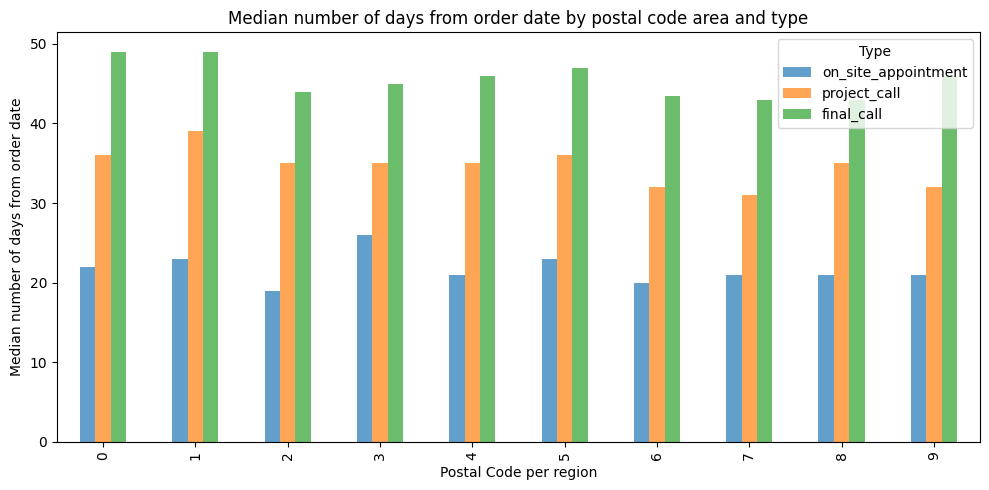

In [21]:
# Group by 'first_digit' and 'type', then calculate the median of 'number_of_days_from_order_date'
median_stats = merged_df.groupby(['first_digit', 'type'])['number_of_days_from_order_date'].median().unstack()

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))

#Ordering type
type_order = ['on_site_appointment', 'project_call', 'final_call']
median_stats = median_stats[type_order]

# Bar plot for median number of days
median_stats.plot(kind='bar', ax=ax, alpha=0.7)

# Adding labels and title to visual
ax.set_ylabel('Median number of days from order date')
ax.set_xlabel('Postal Code per region')
ax.set_title('Median number of days from order date by postal code area and type')
ax.legend(title='Type')

plt.tight_layout()
plt.show()

***What is the average number of days when an order is placed by postal code area and appointment type?***

1) On-Site Appointments:
- Shortest: In Region 2, half of the on-site appointments are completed in around 19 days.
- Longest: In Region 3, half of the on-site appointments take 26 days to take place.
2) Project Calls:
- Shortest: For both regions 6 and 9 , project calls take place with 32 days for half of the customers.
- Longest: In Region 1, half of project calls take 39 days to complete.
3) Final Calls:
- Shortest: In Region 7 and 8, half of the final calls are completed in around 43 days. 
- Longest: Region 0 and region 1 both show that half of the final calls take 49 days to take place, followed by region 5.

***Where are most orders placed?***
Region 1 shows highest number of orders, indicating 14.5% of orders are placed in region 1.

In [22]:
# categorical variable "type"

#total_orders = len(merged_df
#percentage_region_1 = (6933 / total_orders) * 100
#percentage_region_1